# ViT CIFAR-10
load timm ViT and retrain on CIFAR 10

In [1]:
NOQUANT_TRAIN = False

In [2]:
import argparse
import os
import shutil
import time
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import time
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

DATA_DIR = "train"
print_freq = 50

# vit imsize
imsize = 224

In [3]:
# prepare labels
train_df = pd.read_csv("trainLabels.csv")
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_df['label_enc'] = le.fit_transform(train_df['label'])

# 5-fold
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_df["fold"] = -1
for i, (train_index, test_index) in enumerate(skf.split(train_df.id, train_df.label_enc)):
    train_df.loc[test_index, 'fold'] = i
train_df.head()

,id,label,label_enc,fold
0,1,frog,6,1
1,2,truck,9,1
2,3,truck,9,2
3,4,deer,4,1
4,5,automobile,1,2


In [4]:
class cifarDataset(Dataset):
    def __init__(self,
                 df,
                 rand=False,
                 transform=None,
                 test=False
                ):

        self.df = df.reset_index(drop=True)
        self.rand = rand
        self.transform = transform
        self.test = test

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.id
        
        images = cv2.imread(os.path.join(DATA_DIR, str(img_id)+".png"))
        
        # Load labels
        label = row.label_enc
        
        # aug
        if self.transform is not None:
            images = self.transform(image=images)['image']
              
        #images = images.astype(np.float32)
        #images /= 255
        images = images.transpose(2, 0, 1)
        
        label = label.astype(np.float32)
        #label2 = label2.astype(np.float32)
        return torch.tensor(images), torch.tensor(label),

In [5]:
import albumentations as A
import albumentations

transforms_train = albumentations.Compose([
    albumentations.ShiftScaleRotate(scale_limit=0.3, rotate_limit=180,p=0.5),
    A.Cutout(num_holes=12, max_h_size=4, max_w_size=4, fill_value=0, p=0.5),
    #albumentations.Rotate(p=0.5),
    #albumentations.Transpose(p=0.5),
    #albumentations.VerticalFlip(p=0.5),
    albumentations.HorizontalFlip(p=0.5),   
    albumentations.Resize(imsize, imsize, p=1.0), 
    albumentations.Normalize(mean=(0.485, 0.456, 0.406),
                       std=(0.229, 0.224, 0.225), p=1),
])

transforms_val = albumentations.Compose([albumentations.Resize(imsize, imsize, p=1.0),
                                         albumentations.Normalize(mean=(0.485, 0.456, 0.406),
                       std=(0.229, 0.224, 0.225), p=1),])

/home/ken/anaconda3/envs/pytorch_p38_2/lib/python3.8/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

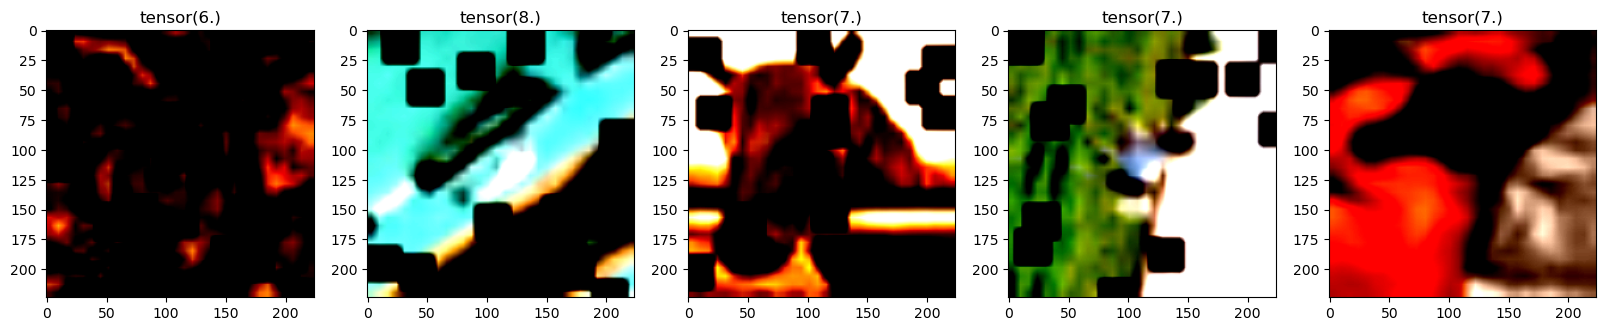

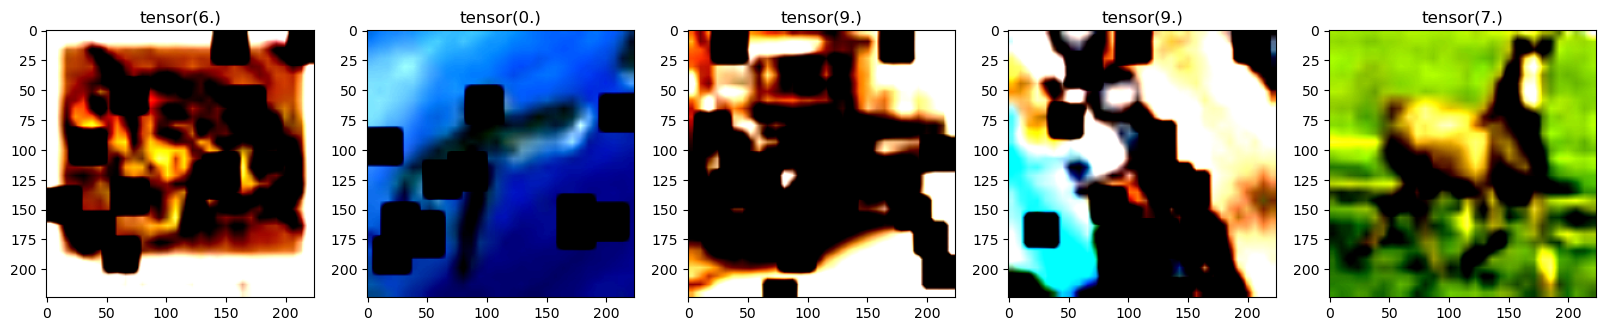

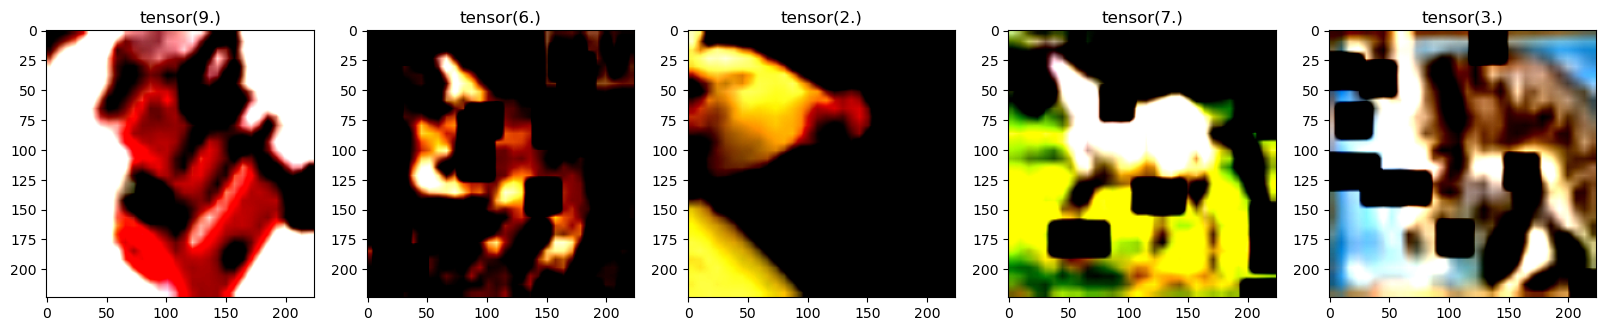

In [6]:
dataset_show = cifarDataset(train_df, transform=transforms_train)
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
for i in range(3):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        img = img.flip(0) #BGR2RGB
        axarr[p].imshow(img.transpose(0,1).transpose(1,2))
        axarr[p].set_title(str(label))
plt.show()

In [7]:
scaler = torch.cuda.amp.GradScaler(enabled=True)
def train(train_loader, model, criterion, optimizer, epoch):
    """
        Run one train epoch
    """
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    lambda_alpha = 0.002
    for i, (input, target) in enumerate(tqdm(train_loader)):
        # measure data loading time
        data_time.update(time.time() - end)
        target2 = target

        target = target.long().cuda()
        target2 = target2.long().cuda()
        input_var = input.cuda()
        target_var = target

        if not mixup:
          alpha = 0
        else:
          alpha = 1
        

        # compute output
        with torch.cuda.amp.autocast(enabled=True):
            output = model(input_var)
            loss = criterion(output, target_var)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        output = output.float()
        loss = loss.float()
        # measure accuracy and record loss
        prec1 = accuracy(output.data, target)[0]
        losses.update(loss.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                      epoch, i, len(train_loader), batch_time=batch_time,
                      data_time=data_time, loss=losses, top1=top1))
    return losses.avg

def validate(val_loader, model, criterion):
    """
    Run evaluation
    """
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            target = target.long().cuda()
            input_var = input.cuda()
            target_var = target.cuda()

            # compute output
            output = model(input_var)
            loss = criterion(output, target_var)

            output = output.float()
            loss = loss.float()

            # measure accuracy and record loss
            prec1 = accuracy(output.data, target)[0]
            losses.update(loss.item(), input.size(0))
            top1.update(prec1.item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % print_freq == 0:
                print('Test: [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                          i, len(val_loader), batch_time=batch_time, loss=losses,
                          top1=top1))

    print(' * Prec@1 {top1.avg:.3f}'
          .format(top1=top1))
    return top1.avg, losses.avg

def save_checkpoint(state, filename='checkpoint.pth'):
    """
    Save the training model
    """
    torch.save(state, filename)

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [8]:
train_dataset = cifarDataset(train_df[train_df.fold!=0], transform=transforms_train)
val_dataset = cifarDataset(train_df[train_df.fold==0], transform=transforms_val, test=True)

train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=256, shuffle=True,
        num_workers=8, pin_memory=True)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=1024, shuffle=False,
    num_workers=8, pin_memory=True)

In [9]:
import timm
net = timm.create_model("mixer_b16_224_in21k", pretrained=True)
net.head = nn.Linear(net.head.in_features, 10)

In [10]:
net.cpu()
net.forward(torch.randn(1,3,224,224))

tensor([[ 1.3227, -3.0026, -1.7829, -0.3006, -1.3275, -0.1591, -1.7673, -0.6899,
          0.9199, -0.6855]], grad_fn=<AddmmBackward0>)

In [11]:
torch.__version__

'1.10.1'

# Train VIT without quantization

In [12]:
import timm
modelname = "resmlp_24_224_dino"
net = timm.create_model(modelname, pretrained=True)
net.head = nn.Linear(net.head.in_features, 10)

model = net.cuda()
mixup = False

import wandb
watermark = modelname
wandb.init(project="pact_mlp",
            name=watermark)

# define loss function (criterion) and pptimizer
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=4e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 100)

best_prec1 = 0
os.makedirs("models", exist_ok=True)

if NOQUANT_TRAIN:
    for epoch in range(100):
        # train for one epoch
        print('current lr {:.5e}'.format(optimizer.param_groups[0]['lr']))
        tloss = train(train_loader, model, criterion, optimizer, epoch)
        scheduler.step(epoch)

        # evaluate on validation set
        prec1, valloss = validate(val_loader, model, criterion)

        # wandb
        wandb.log({'epoch': epoch, "prec":prec1, "train_loss": tloss, 'val_loss': valloss, "lr": optimizer.param_groups[0]["lr"],})

        # remember best prec@1 and save checkpoint
        is_best = prec1 > best_prec1
        best_prec1 = max(prec1, best_prec1)

        print("Best prec1 : ", best_prec1)
        if is_best:
            torch.save(model.state_dict(), os.path.join(f'models/{watermark}.pth'))

wandb: Currently logged in as: arutema47 (keio-csg). Use `wandb login --relogin` to force relogin


# Hack timm models with quantization layers

In [13]:
import math
from copy import deepcopy
from functools import partial

import torch
import torch.nn as nn

from timm.models.helpers import build_model_with_cfg, named_apply, checkpoint_seq
from timm.models.layers import PatchEmbed, GluMlp, GatedMlp, DropPath, lecun_normal_, to_2tuple
from timm.models.registry import register_model

from pact_utils import QuantizedLinear

# Hacked Mlp layer
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0., kw=8, ki=8):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        pact = False
        self.fc1 = QuantizedLinear(in_features, hidden_features, True, kw, ki, pact)
        self.act = act_layer()
        self.fc2 = QuantizedLinear(hidden_features, out_features, True, kw, ki, pact)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class MixerBlock(nn.Module):
    """ Residual Block w/ token mixing and channel MLPs
    Based on: 'MLP-Mixer: An all-MLP Architecture for Vision' - https://arxiv.org/abs/2105.01601
    """
    def __init__(
            self, dim, seq_len, mlp_ratio=(0.5, 4.0), mlp_layer=Mlp,
            norm_layer=partial(nn.LayerNorm, eps=1e-6), act_layer=nn.GELU, drop=0., drop_path=0., kw1=8, ki1=8, kw2=8, ki2=8):
        super().__init__()
        tokens_dim, channels_dim = [int(x * dim) for x in to_2tuple(mlp_ratio)]
        self.norm1 = norm_layer(dim)
        self.mlp_tokens = mlp_layer(seq_len, tokens_dim, act_layer=act_layer, drop=drop, kw=kw1, ki=ki1) # attention
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        self.mlp_channels = mlp_layer(dim, channels_dim, act_layer=act_layer, drop=drop, kw=kw2, ki=ki2) # mix

    def forward(self, x):
        x = x + self.drop_path(self.mlp_tokens(self.norm1(x).transpose(1, 2)).transpose(1, 2))
        x = x + self.drop_path(self.mlp_channels(self.norm2(x)))
        return x


class Affine(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.alpha = nn.Parameter(torch.ones((1, 1, dim)))
        self.beta = nn.Parameter(torch.zeros((1, 1, dim)))

    def forward(self, x):
        return torch.addcmul(self.beta, self.alpha, x)


class ResBlock(nn.Module):
    """ Residual MLP block w/ LayerScale and Affine 'norm'
    Based on: `ResMLP: Feedforward networks for image classification...` - https://arxiv.org/abs/2105.03404
    """
    def __init__(
            self, dim, seq_len, mlp_ratio=4, mlp_layer=Mlp, norm_layer=Affine,
            act_layer=nn.GELU, init_values=1e-4, drop=0., drop_path=0., kw1=8,ki1=8,kw2=8,ki2=8):
        super().__init__()
        channel_dim = int(dim * mlp_ratio)
        self.norm1 = norm_layer(dim)
        self.linear_tokens = QuantizedLinear(seq_len, seq_len, True, kw1, ki1)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        self.mlp_channels = mlp_layer(dim, channel_dim, act_layer=act_layer, drop=drop, kw=kw2, ki=ki2)
        self.ls1 = nn.Parameter(init_values * torch.ones(dim))
        self.ls2 = nn.Parameter(init_values * torch.ones(dim))

    def forward(self, x):
        x = x + self.drop_path(self.ls1 * self.linear_tokens(self.norm1(x).transpose(1, 2)).transpose(1, 2))
        x = x + self.drop_path(self.ls2 * self.mlp_channels(self.norm2(x)))
        return x


class SpatialGatingUnit(nn.Module):
    """ Spatial Gating Unit
    Based on: `Pay Attention to MLPs` - https://arxiv.org/abs/2105.08050
    """
    def __init__(self, dim, seq_len, norm_layer=nn.LayerNorm):
        super().__init__()
        gate_dim = dim // 2
        self.norm = norm_layer(gate_dim)
        self.proj = nn.Linear(seq_len, seq_len)

    def init_weights(self):
        # special init for the projection gate, called as override by base model init
        nn.init.normal_(self.proj.weight, std=1e-6)
        nn.init.ones_(self.proj.bias)

    def forward(self, x):
        u, v = x.chunk(2, dim=-1)
        v = self.norm(v)
        v = self.proj(v.transpose(-1, -2))
        return u * v.transpose(-1, -2)


class SpatialGatingBlock(nn.Module):
    """ Residual Block w/ Spatial Gating
    Based on: `Pay Attention to MLPs` - https://arxiv.org/abs/2105.08050
    """
    def __init__(
            self, dim, seq_len, mlp_ratio=4, mlp_layer=GatedMlp,
            norm_layer=partial(nn.LayerNorm, eps=1e-6), act_layer=nn.GELU, drop=0., drop_path=0.):
        super().__init__()
        channel_dim = int(dim * mlp_ratio)
        self.norm = norm_layer(dim)
        sgu = partial(SpatialGatingUnit, seq_len=seq_len)
        self.mlp_channels = mlp_layer(dim, channel_dim, act_layer=act_layer, gate_layer=sgu, drop=drop)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        x = x + self.drop_path(self.mlp_channels(self.norm(x)))
        return x


class MlpMixer(nn.Module):

    def __init__(
            self,
            num_classes=1000,
            img_size=224,
            in_chans=3,
            patch_size=16,
            num_blocks=8,
            embed_dim=512,
            mlp_ratio=(0.5, 4.0),
            block_layer=MixerBlock,
            mlp_layer=Mlp,
            norm_layer=partial(nn.LayerNorm, eps=1e-6),
            act_layer=nn.GELU,
            drop_rate=0.,
            drop_path_rate=0.,
            nlhb=False,
            stem_norm=False,
            global_pool='avg',
            kw1=8,
            ki1=8,
            kw2=8,
            ki2=8
    ):
        super().__init__()
        self.num_classes = num_classes
        self.global_pool = global_pool
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        self.grad_checkpointing = False

        self.stem = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans,
            embed_dim=embed_dim, norm_layer=norm_layer if stem_norm else None)
        # FIXME drop_path (stochastic depth scaling rule or all the same?)
        self.blocks = nn.Sequential(*[
            block_layer(
                embed_dim, self.stem.num_patches, mlp_ratio, mlp_layer=mlp_layer, norm_layer=norm_layer,
                act_layer=act_layer, drop=drop_rate, drop_path=drop_path_rate, kw1=kw1,ki1=ki1,kw2=kw2,ki2=ki2)# Add quant bits
            for _ in range(num_blocks)])
        self.norm = norm_layer(embed_dim)
        self.head = nn.Linear(embed_dim, self.num_classes) if num_classes > 0 else nn.Identity()

        self.init_weights(nlhb=nlhb)

    @torch.jit.ignore
    def init_weights(self, nlhb=False):
        head_bias = -math.log(self.num_classes) if nlhb else 0.
        named_apply(partial(_init_weights, head_bias=head_bias), module=self)  # depth-first

    @torch.jit.ignore
    def group_matcher(self, coarse=False):
        return dict(
            stem=r'^stem',  # stem and embed
            blocks=[(r'^blocks\.(\d+)', None), (r'^norm', (99999,))]
        )

    @torch.jit.ignore
    def set_grad_checkpointing(self, enable=True):
        self.grad_checkpointing = enable

    @torch.jit.ignore
    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes, global_pool=None):
        self.num_classes = num_classes
        if global_pool is not None:
            assert global_pool in ('', 'avg')
            self.global_pool = global_pool
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        x = self.stem(x)
        if self.grad_checkpointing and not torch.jit.is_scripting():
            x = checkpoint_seq(self.blocks, x)
        else:
            x = self.blocks(x)
        x = self.norm(x)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        if self.global_pool == 'avg':
            x = x.mean(dim=1)
        x = self.head(x)
        return x


def _init_weights(module: nn.Module, name: str, head_bias: float = 0., flax=False):
    if isinstance(module, nn.Linear):
        if name.startswith('head'):
            nn.init.zeros_(module.weight)
            nn.init.constant_(module.bias, head_bias)
        else:
            if flax:
                # Flax defaults
                lecun_normal_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
            else:
                # like MLP init in vit (my original init)
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    if 'mlp' in name:
                        nn.init.normal_(module.bias, std=1e-6)
                    else:
                        nn.init.zeros_(module.bias)
    elif isinstance(module, nn.Conv2d):
        lecun_normal_(module.weight)
        if module.bias is not None:
            nn.init.zeros_(module.bias)
    elif isinstance(module, (nn.LayerNorm, nn.BatchNorm2d, nn.GroupNorm)):
        nn.init.ones_(module.weight)
        nn.init.zeros_(module.bias)
    elif hasattr(module, 'init_weights'):
        # NOTE if a parent module contains init_weights method, it can override the init of the
        # child modules as this will be called in depth-first order.
        module.init_weights()


def checkpoint_filter_fn(state_dict, model):
    """ Remap checkpoints if needed """
    if 'patch_embed.proj.weight' in state_dict:
        # Remap FB ResMlp models -> timm
        out_dict = {}
        for k, v in state_dict.items():
            k = k.replace('patch_embed.', 'stem.')
            k = k.replace('attn.', 'linear_tokens.')
            k = k.replace('mlp.', 'mlp_channels.')
            k = k.replace('gamma_', 'ls')
            if k.endswith('.alpha') or k.endswith('.beta'):
                v = v.reshape(1, 1, -1)
            out_dict[k] = v
        return out_dict
    return state_dict


def _create_mixer(variant, pretrained=False, **kwargs):
    if kwargs.get('features_only', None):
        raise RuntimeError('features_only not implemented for MLP-Mixer models.')

    model = build_model_with_cfg(
        MlpMixer, variant, pretrained,
        pretrained_filter_fn=checkpoint_filter_fn,
        **kwargs)
    return model

def mixer_b16_224(pretrained=False, **kwargs):
    """ Mixer-B/16 224x224. ImageNet-1k pretrained weights.
    Paper:  'MLP-Mixer: An all-MLP Architecture for Vision' - https://arxiv.org/abs/2105.01601
    """
    model_args = dict(patch_size=16, num_blocks=12, embed_dim=768, **kwargs)
    model = _create_mixer('mixer_b16_224', pretrained=pretrained, **model_args)
    return model

def resmlp_24_224_dino(pretrained=False, **kwargs):
    """ ResMLP-24
    Paper: `ResMLP: Feedforward networks for image classification...` - https://arxiv.org/abs/2105.03404
    Model pretrained via DINO (self-supervised) - https://arxiv.org/abs/2104.14294
    """
    model_args = dict(
        patch_size=16, num_blocks=24, embed_dim=384, mlp_ratio=4,
        block_layer=partial(ResBlock, init_values=1e-5), norm_layer=Affine, **kwargs)
    model = _create_mixer('resmlp_24_224_dino', pretrained=pretrained, **model_args)
    return model

def resmlp_12_224_dino(pretrained=False, **kwargs):
    """ ResMLP-12
    Paper: `ResMLP: Feedforward networks for image classification...` - https://arxiv.org/abs/2105.03404
    Model pretrained via DINO (self-supervised) - https://arxiv.org/abs/2104.14294
    """
    model_args = dict(
        patch_size=16, num_blocks=12, embed_dim=384, mlp_ratio=4, block_layer=ResBlock, norm_layer=Affine, **kwargs)
    model = _create_mixer('resmlp_12_224_dino', pretrained=pretrained, **model_args)
    return model

### Actual trainin

In [ ]:
from timm.scheduler import CosineLRScheduler

for PACT in [False]:
    for attenkw in [4,5,6,7,8]:
        for kw in [5,6,7,8]:
            net = resmlp_24_224_dino(False, kw1=attenkw, ki1=attenkw, kw2=kw, ki2=kw)
            net.head = nn.Linear(net.head.in_features, 10)
            checkpoint = torch.load("models/resmlp_24_224_dino.pth")
            net.load_state_dict(checkpoint, strict=False)

            model = net.cuda()
            mixup = False

            # Track experiment with wandb
            import wandb
            watermark = "resmlp_k{}_attenk{}".format(kw, attenkw)

            # mess with wandb
            wandb.init(project="pact_mlp_quant", name=watermark)

            # define loss function (criterion) and pptimizer
            criterion = nn.CrossEntropyLoss().cuda()

            # optimizer for pact
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
            scheduler = CosineLRScheduler(optimizer, t_initial=10, lr_min=1e-6, 
                                  warmup_t=3, warmup_lr_init=5e-5, warmup_prefix=True)

            best_prec1 = 0
            os.makedirs("models", exist_ok=True)
            scaler = torch.cuda.amp.GradScaler(enabled=True)

            for epoch in range(10):
                scheduler.step(epoch)
                # train for one epoch
                print('current lr {:.5e}'.format(optimizer.param_groups[0]['lr']))
                tloss = train(train_loader, model, criterion, optimizer, epoch)         

                # evaluate on validation set
                prec1, valloss = validate(val_loader, model, criterion)

                # wandb
                wandb.log({'epoch': epoch, "prec":prec1, "train_loss": tloss, 'val_loss': valloss, "lr": optimizer.param_groups[0]["lr"],})

                # remember best prec@1 and save checkpoint
                is_best = prec1 > best_prec1
                best_prec1 = max(prec1, best_prec1)

                print("Best prec1 : ", best_prec1)
                if is_best:
                    torch.save(model.state_dict(), os.path.join(f'models/{watermark}.pth'))
                if prec1 < 60:
                    break

current lr 5.00000e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [0][0/157]	Time 5.751 (5.751)	Data 1.513 (1.513)	Loss 2.7440 (2.7440)	Prec@1 10.547 (10.547)
Epoch: [0][50/157]	Time 2.246 (2.310)	Data 0.001 (0.031)	Loss 1.4001 (1.9662)	Prec@1 50.000 (29.887)
Epoch: [0][100/157]	Time 2.252 (2.279)	Data 0.001 (0.016)	Loss 0.7855 (1.5307)	Prec@1 71.875 (46.426)
Epoch: [0][150/157]	Time 2.248 (2.270)	Data 0.001 (0.011)	Loss 0.7555 (1.3026)	Prec@1 74.609 (54.838)
Test: [0/10]	Time 8.499 (8.499)	Loss 0.4345 (0.4345)	Prec@1 86.426 (86.426)
 * Prec@1 83.860
Best prec1 :  83.86000021972656
current lr 6.66667e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [1][0/157]	Time 2.969 (2.969)	Data 0.707 (0.707)	Loss 0.6808 (0.6808)	Prec@1 78.516 (78.516)
Epoch: [1][50/157]	Time 2.256 (2.265)	Data 0.001 (0.015)	Loss 0.9164 (0.8431)	Prec@1 72.656 (72.235)
Epoch: [1][100/157]	Time 2.255 (2.258)	Data 0.001 (0.008)	Loss 0.7021 (0.8549)	Prec@1 76.953 (72.030)
Epoch: [1][150/157]	Time 2.256 (2.256)	Data 0.001 (0.006)	Loss 0.6486 (0.8410)	Prec@1 80.859 (72.770)
Test: [0/10]	Time 8.065 (8.065)	Loss 0.4584 (0.4584)	Prec@1 84.277 (84.277)
 * Prec@1 84.690
Best prec1 :  84.69000008544921
current lr 8.33333e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [2][0/157]	Time 3.150 (3.150)	Data 0.900 (0.900)	Loss 0.8783 (0.8783)	Prec@1 68.750 (68.750)
Epoch: [2][50/157]	Time 2.252 (2.269)	Data 0.001 (0.019)	Loss 0.7423 (0.7986)	Prec@1 79.688 (74.334)
Epoch: [2][100/157]	Time 1.047 (1.776)	Data 0.001 (0.010)	Loss 1.0557 (0.8305)	Prec@1 70.312 (73.604)
Epoch: [2][150/157]	Time 1.048 (1.535)	Data 0.001 (0.007)	Loss 0.7402 (0.8175)	Prec@1 75.781 (74.255)
Test: [0/10]	Time 5.389 (5.389)	Loss 0.5286 (0.5286)	Prec@1 83.789 (83.789)
 * Prec@1 83.880
Best prec1 :  84.69000008544921
current lr 1.00000e-04


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [3][0/157]	Time 2.079 (2.079)	Data 1.028 (1.028)	Loss 0.8959 (0.8959)	Prec@1 74.609 (74.609)
Epoch: [3][50/157]	Time 1.046 (1.067)	Data 0.001 (0.021)	Loss 0.9371 (0.8142)	Prec@1 69.922 (74.494)
Epoch: [3][100/157]	Time 1.047 (1.057)	Data 0.001 (0.011)	Loss 1.1329 (0.8606)	Prec@1 68.750 (73.708)
Epoch: [3][150/157]	Time 1.046 (1.053)	Data 0.001 (0.008)	Loss 1.0949 (0.9108)	Prec@1 66.797 (73.016)
Test: [0/10]	Time 5.135 (5.135)	Loss 0.6202 (0.6202)	Prec@1 82.812 (82.812)
 * Prec@1 82.390
Best prec1 :  84.69000008544921
current lr 9.75773e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [4][0/157]	Time 1.987 (1.987)	Data 0.938 (0.938)	Loss 1.1023 (1.1023)	Prec@1 66.406 (66.406)
Epoch: [4][50/157]	Time 1.046 (1.064)	Data 0.001 (0.019)	Loss 1.2670 (1.0521)	Prec@1 68.750 (71.117)
Epoch: [4][100/157]	Time 1.046 (1.055)	Data 0.001 (0.010)	Loss 0.7749 (1.0775)	Prec@1 78.906 (71.341)
Epoch: [4][150/157]	Time 1.046 (1.052)	Data 0.001 (0.007)	Loss 1.6631 (1.1033)	Prec@1 66.797 (71.456)
Test: [0/10]	Time 4.542 (4.542)	Loss 1.0712 (1.0712)	Prec@1 75.879 (75.879)
 * Prec@1 73.760
Best prec1 :  84.69000008544921
current lr 9.05463e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [5][0/157]	Time 1.989 (1.989)	Data 0.941 (0.941)	Loss 1.6287 (1.6287)	Prec@1 62.500 (62.500)
Epoch: [5][50/157]	Time 1.045 (1.064)	Data 0.001 (0.019)	Loss 1.2280 (1.1754)	Prec@1 72.656 (71.071)
Epoch: [5][100/157]	Time 1.046 (1.055)	Data 0.001 (0.010)	Loss 2.4448 (1.7366)	Prec@1 61.719 (67.926)
Epoch: [5][150/157]	Time 1.044 (1.052)	Data 0.001 (0.007)	Loss 4.6704 (2.1795)	Prec@1 58.984 (65.868)
Test: [0/10]	Time 5.466 (5.466)	Loss 5.0315 (5.0315)	Prec@1 56.641 (56.641)
 * Prec@1 59.550
Best prec1 :  84.69000008544921


epoch,▁▂▄▅▇█
lr,▁▃▆██▇
prec,███▇▅▁
train_loss,▃▁▁▁▂█
val_loss,▁▁▁▁▂█
epoch,5
lr,9e-05
prec,59.55
train_loss,2.27244
val_loss,5.18766


current lr 5.00000e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [0][0/157]	Time 1.810 (1.810)	Data 0.779 (0.779)	Loss 3.2210 (3.2210)	Prec@1 10.938 (10.938)
Epoch: [0][50/157]	Time 1.044 (1.058)	Data 0.001 (0.016)	Loss 0.7347 (1.4570)	Prec@1 73.047 (50.452)
Epoch: [0][100/157]	Time 1.046 (1.052)	Data 0.001 (0.009)	Loss 0.5310 (1.0238)	Prec@1 82.812 (65.060)
Epoch: [0][150/157]	Time 1.045 (1.050)	Data 0.001 (0.006)	Loss 0.4967 (0.8557)	Prec@1 82.422 (70.794)
Test: [0/10]	Time 4.878 (4.878)	Loss 0.2283 (0.2283)	Prec@1 92.773 (92.773)
 * Prec@1 92.060
Best prec1 :  92.06000014648437
current lr 6.66667e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [1][0/157]	Time 2.140 (2.140)	Data 1.091 (1.091)	Loss 0.4797 (0.4797)	Prec@1 83.594 (83.594)
Epoch: [1][50/157]	Time 1.045 (1.066)	Data 0.001 (0.022)	Loss 0.5617 (0.5389)	Prec@1 80.078 (81.556)
Epoch: [1][100/157]	Time 1.045 (1.056)	Data 0.001 (0.012)	Loss 0.5740 (0.5174)	Prec@1 79.688 (82.310)
Epoch: [1][150/157]	Time 1.045 (1.052)	Data 0.001 (0.008)	Loss 0.4427 (0.5072)	Prec@1 83.984 (82.678)
Test: [0/10]	Time 5.253 (5.253)	Loss 0.2411 (0.2411)	Prec@1 91.699 (91.699)
 * Prec@1 91.120
Best prec1 :  92.06000014648437
current lr 8.33333e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [2][0/157]	Time 2.038 (2.038)	Data 0.990 (0.990)	Loss 0.4567 (0.4567)	Prec@1 84.375 (84.375)
Epoch: [2][50/157]	Time 1.046 (1.065)	Data 0.001 (0.020)	Loss 0.6974 (0.5726)	Prec@1 79.297 (80.254)
Epoch: [2][100/157]	Time 1.046 (1.055)	Data 0.001 (0.011)	Loss 0.4326 (0.5495)	Prec@1 84.766 (81.138)
Epoch: [2][150/157]	Time 1.045 (1.052)	Data 0.001 (0.008)	Loss 0.3683 (0.5147)	Prec@1 88.281 (82.440)
Test: [0/10]	Time 4.686 (4.686)	Loss 0.2162 (0.2162)	Prec@1 92.480 (92.480)
 * Prec@1 92.160
Best prec1 :  92.16000004882812
current lr 1.00000e-04


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [3][0/157]	Time 1.989 (1.989)	Data 0.939 (0.939)	Loss 0.4815 (0.4815)	Prec@1 84.375 (84.375)
Epoch: [3][50/157]	Time 1.045 (1.063)	Data 0.001 (0.019)	Loss 0.4043 (0.4573)	Prec@1 87.500 (84.291)
Epoch: [3][100/157]	Time 1.045 (1.055)	Data 0.001 (0.010)	Loss 0.4063 (0.4462)	Prec@1 85.547 (84.750)
Epoch: [3][150/157]	Time 1.046 (1.052)	Data 0.001 (0.007)	Loss 0.4639 (0.4483)	Prec@1 84.766 (84.641)
Test: [0/10]	Time 5.160 (5.160)	Loss 0.2720 (0.2720)	Prec@1 91.406 (91.406)
 * Prec@1 91.020
Best prec1 :  92.16000004882812
current lr 9.75773e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [4][0/157]	Time 2.073 (2.073)	Data 1.023 (1.023)	Loss 0.4267 (0.4267)	Prec@1 85.547 (85.547)
Epoch: [4][50/157]	Time 1.045 (1.066)	Data 0.001 (0.021)	Loss 0.3768 (0.4471)	Prec@1 87.500 (84.965)
Epoch: [4][100/157]	Time 1.045 (1.056)	Data 0.001 (0.011)	Loss 0.4375 (0.4344)	Prec@1 85.156 (85.179)
Epoch: [4][150/157]	Time 1.045 (1.052)	Data 0.001 (0.008)	Loss 0.3128 (0.4285)	Prec@1 87.500 (85.208)
Test: [0/10]	Time 4.590 (4.590)	Loss 0.2036 (0.2036)	Prec@1 92.676 (92.676)
 * Prec@1 92.640
Best prec1 :  92.64000004882813
current lr 9.05463e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [5][0/157]	Time 2.125 (2.125)	Data 1.076 (1.076)	Loss 0.3975 (0.3975)	Prec@1 87.891 (87.891)
Epoch: [5][50/157]	Time 1.045 (1.067)	Data 0.001 (0.022)	Loss 0.3211 (0.3947)	Prec@1 89.062 (86.497)
Epoch: [5][100/157]	Time 1.047 (1.057)	Data 0.001 (0.012)	Loss 0.3780 (0.3949)	Prec@1 86.328 (86.409)
Epoch: [5][150/157]	Time 1.046 (1.053)	Data 0.001 (0.008)	Loss 0.4774 (0.3889)	Prec@1 85.156 (86.556)
Test: [0/10]	Time 4.522 (4.522)	Loss 0.2564 (0.2564)	Prec@1 91.406 (91.406)
 * Prec@1 92.130
Best prec1 :  92.64000004882813
current lr 7.95954e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [6][0/157]	Time 2.293 (2.293)	Data 1.245 (1.245)	Loss 0.3369 (0.3369)	Prec@1 88.281 (88.281)
Epoch: [6][50/157]	Time 1.048 (1.070)	Data 0.001 (0.025)	Loss 0.2977 (0.3648)	Prec@1 89.453 (87.607)
Epoch: [6][100/157]	Time 1.046 (1.058)	Data 0.001 (0.013)	Loss 0.3638 (0.3562)	Prec@1 87.891 (87.778)
Epoch: [6][150/157]	Time 1.046 (1.054)	Data 0.001 (0.009)	Loss 0.2585 (0.3509)	Prec@1 90.234 (87.945)
Test: [0/10]	Time 4.972 (4.972)	Loss 0.2283 (0.2283)	Prec@1 93.262 (93.262)
 * Prec@1 92.800
Best prec1 :  92.7999999267578
current lr 6.57963e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [7][0/157]	Time 2.187 (2.187)	Data 1.138 (1.138)	Loss 0.4172 (0.4172)	Prec@1 88.672 (88.672)
Epoch: [7][50/157]	Time 1.046 (1.068)	Data 0.001 (0.023)	Loss 0.3989 (0.3384)	Prec@1 89.453 (88.611)
Epoch: [7][100/157]	Time 1.047 (1.057)	Data 0.001 (0.012)	Loss 0.2402 (0.3149)	Prec@1 92.188 (89.341)
Epoch: [7][150/157]	Time 1.046 (1.053)	Data 0.001 (0.008)	Loss 0.3363 (0.3148)	Prec@1 91.016 (89.306)
Test: [0/10]	Time 4.723 (4.723)	Loss 0.2158 (0.2158)	Prec@1 94.141 (94.141)
 * Prec@1 93.060
Best prec1 :  93.05999986572266
current lr 5.05000e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [8][0/157]	Time 2.114 (2.114)	Data 1.067 (1.067)	Loss 0.3385 (0.3385)	Prec@1 87.500 (87.500)
Epoch: [8][50/157]	Time 1.046 (1.066)	Data 0.001 (0.022)	Loss 0.3052 (0.2867)	Prec@1 90.625 (89.997)
Epoch: [8][100/157]	Time 1.046 (1.056)	Data 0.001 (0.012)	Loss 0.2744 (0.2806)	Prec@1 89.453 (90.238)
Epoch: [8][150/157]	Time 1.052 (1.053)	Data 0.001 (0.008)	Loss 0.2126 (0.2788)	Prec@1 92.969 (90.397)
Test: [0/10]	Time 4.541 (4.541)	Loss 0.1401 (0.1401)	Prec@1 95.508 (95.508)
 * Prec@1 94.350
Best prec1 :  94.34999984130859
current lr 3.52037e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [9][0/157]	Time 1.808 (1.808)	Data 0.759 (0.759)	Loss 0.1916 (0.1916)	Prec@1 93.750 (93.750)
Epoch: [9][50/157]	Time 1.045 (1.060)	Data 0.001 (0.016)	Loss 0.2267 (0.2437)	Prec@1 89.844 (91.751)
Epoch: [9][100/157]	Time 1.045 (1.053)	Data 0.001 (0.008)	Loss 0.2239 (0.2458)	Prec@1 91.406 (91.607)
Epoch: [9][150/157]	Time 1.045 (1.050)	Data 0.001 (0.006)	Loss 0.2180 (0.2469)	Prec@1 92.969 (91.621)
Test: [0/10]	Time 4.847 (4.847)	Loss 0.1423 (0.1423)	Prec@1 95.801 (95.801)
 * Prec@1 94.910
Best prec1 :  94.90999974365235


epoch,▁▂▃▃▄▅▆▆▇█
lr,▃▄▆██▇▆▄▃▁
prec,▃▁▃▁▄▃▄▅▇█
train_loss,█▄▄▃▃▃▂▂▁▁
val_loss,▆▇▅█▄▅▅▄▁▁
epoch,9
lr,4e-05
prec,94.91
train_loss,0.24825
val_loss,0.17425


current lr 5.00000e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [0][0/157]	Time 1.977 (1.977)	Data 0.946 (0.946)	Loss 1.6927 (1.6927)	Prec@1 41.406 (41.406)
Epoch: [0][50/157]	Time 1.044 (1.061)	Data 0.001 (0.020)	Loss 0.4999 (0.7184)	Prec@1 82.422 (76.103)
Epoch: [0][100/157]	Time 1.045 (1.053)	Data 0.001 (0.010)	Loss 0.4185 (0.5870)	Prec@1 86.328 (80.051)
Epoch: [0][150/157]	Time 1.045 (1.051)	Data 0.001 (0.007)	Loss 0.5569 (0.5329)	Prec@1 82.812 (81.845)
Test: [0/10]	Time 5.022 (5.022)	Loss 0.2178 (0.2178)	Prec@1 93.066 (93.066)
 * Prec@1 92.720
Best prec1 :  92.71999986572266
current lr 6.66667e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [1][0/157]	Time 2.120 (2.120)	Data 1.071 (1.071)	Loss 0.4432 (0.4432)	Prec@1 81.641 (81.641)
Epoch: [1][50/157]	Time 1.045 (1.065)	Data 0.001 (0.022)	Loss 0.4518 (0.4338)	Prec@1 83.203 (84.819)
Epoch: [1][100/157]	Time 1.045 (1.055)	Data 0.001 (0.012)	Loss 0.3569 (0.4306)	Prec@1 89.062 (85.079)
Epoch: [1][150/157]	Time 1.045 (1.052)	Data 0.001 (0.008)	Loss 0.4609 (0.4253)	Prec@1 82.812 (85.343)
Test: [0/10]	Time 5.318 (5.318)	Loss 0.2381 (0.2381)	Prec@1 92.773 (92.773)
 * Prec@1 92.460
Best prec1 :  92.71999986572266
current lr 8.33333e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [2][0/157]	Time 2.224 (2.224)	Data 1.175 (1.175)	Loss 0.4554 (0.4554)	Prec@1 82.812 (82.812)
Epoch: [2][50/157]	Time 1.044 (1.068)	Data 0.001 (0.024)	Loss 0.4226 (0.4214)	Prec@1 84.375 (85.141)
Epoch: [2][100/157]	Time 1.045 (1.056)	Data 0.001 (0.013)	Loss 0.3651 (0.4177)	Prec@1 88.281 (85.369)
Epoch: [2][150/157]	Time 1.045 (1.053)	Data 0.001 (0.009)	Loss 0.4262 (0.4080)	Prec@1 85.547 (85.813)
Test: [0/10]	Time 4.900 (4.900)	Loss 0.2004 (0.2004)	Prec@1 93.555 (93.555)
 * Prec@1 92.790
Best prec1 :  92.79000004882812
current lr 1.00000e-04


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [3][0/157]	Time 1.935 (1.935)	Data 0.887 (0.887)	Loss 0.4345 (0.4345)	Prec@1 83.984 (83.984)
Epoch: [3][50/157]	Time 1.045 (1.062)	Data 0.001 (0.018)	Loss 0.4193 (0.3816)	Prec@1 87.500 (86.749)
Epoch: [3][100/157]	Time 1.045 (1.054)	Data 0.001 (0.010)	Loss 0.3296 (0.3873)	Prec@1 89.453 (86.518)
Epoch: [3][150/157]	Time 1.045 (1.051)	Data 0.001 (0.007)	Loss 0.4782 (0.3895)	Prec@1 85.547 (86.486)
Test: [0/10]	Time 5.073 (5.073)	Loss 0.2008 (0.2008)	Prec@1 92.969 (92.969)
 * Prec@1 92.320
Best prec1 :  92.79000004882812
current lr 9.75773e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [4][0/157]	Time 1.971 (1.971)	Data 0.923 (0.923)	Loss 0.4245 (0.4245)	Prec@1 85.938 (85.938)
Epoch: [4][50/157]	Time 1.045 (1.063)	Data 0.001 (0.019)	Loss 0.3338 (0.3718)	Prec@1 88.672 (87.071)
Epoch: [4][100/157]	Time 1.045 (1.054)	Data 0.001 (0.010)	Loss 0.3638 (0.3653)	Prec@1 86.719 (87.106)
Epoch: [4][150/157]	Time 1.045 (1.051)	Data 0.001 (0.007)	Loss 0.3747 (0.3634)	Prec@1 87.109 (87.249)
Test: [0/10]	Time 5.281 (5.281)	Loss 0.1947 (0.1947)	Prec@1 93.164 (93.164)
 * Prec@1 93.070
Best prec1 :  93.0699996826172
current lr 9.05463e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [5][0/157]	Time 1.773 (1.773)	Data 0.721 (0.721)	Loss 0.3971 (0.3971)	Prec@1 86.328 (86.328)
Epoch: [5][50/157]	Time 1.045 (1.059)	Data 0.001 (0.015)	Loss 0.3168 (0.3307)	Prec@1 87.500 (88.687)
Epoch: [5][100/157]	Time 1.046 (1.052)	Data 0.001 (0.008)	Loss 0.3875 (0.3247)	Prec@1 85.547 (88.695)
Epoch: [5][150/157]	Time 1.045 (1.050)	Data 0.001 (0.006)	Loss 0.2919 (0.3247)	Prec@1 88.281 (88.677)
Test: [0/10]	Time 5.398 (5.398)	Loss 0.1835 (0.1835)	Prec@1 94.043 (94.043)
 * Prec@1 94.600
Best prec1 :  94.60000006103516
current lr 7.95954e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [6][0/157]	Time 2.019 (2.019)	Data 0.971 (0.971)	Loss 0.2496 (0.2496)	Prec@1 91.016 (91.016)
Epoch: [6][50/157]	Time 1.045 (1.064)	Data 0.001 (0.020)	Loss 0.1826 (0.2865)	Prec@1 94.531 (89.928)
Epoch: [6][100/157]	Time 1.046 (1.055)	Data 0.001 (0.011)	Loss 0.2463 (0.2794)	Prec@1 92.188 (90.296)
Epoch: [6][150/157]	Time 1.045 (1.052)	Data 0.001 (0.007)	Loss 0.2525 (0.2800)	Prec@1 89.453 (90.245)
Test: [0/10]	Time 5.409 (5.409)	Loss 0.1801 (0.1801)	Prec@1 93.262 (93.262)
 * Prec@1 93.340
Best prec1 :  94.60000006103516
current lr 6.57963e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [7][0/157]	Time 2.101 (2.101)	Data 1.052 (1.052)	Loss 0.2156 (0.2156)	Prec@1 92.969 (92.969)
Epoch: [7][50/157]	Time 1.045 (1.066)	Data 0.001 (0.022)	Loss 0.3359 (0.2501)	Prec@1 87.500 (91.314)
Epoch: [7][100/157]	Time 1.047 (1.056)	Data 0.001 (0.011)	Loss 0.1772 (0.2488)	Prec@1 92.969 (91.306)
Epoch: [7][150/157]	Time 1.045 (1.052)	Data 0.001 (0.008)	Loss 0.2759 (0.2475)	Prec@1 91.406 (91.264)
Test: [0/10]	Time 4.506 (4.506)	Loss 0.1423 (0.1423)	Prec@1 95.410 (95.410)
 * Prec@1 95.130
Best prec1 :  95.12999965820312
current lr 5.05000e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [8][0/157]	Time 1.786 (1.786)	Data 0.737 (0.737)	Loss 0.1930 (0.1930)	Prec@1 93.750 (93.750)
Epoch: [8][50/157]	Time 1.045 (1.060)	Data 0.001 (0.015)	Loss 0.2137 (0.2216)	Prec@1 91.406 (92.195)
Epoch: [8][100/157]	Time 1.046 (1.053)	Data 0.001 (0.008)	Loss 0.1903 (0.2223)	Prec@1 92.188 (92.129)
Epoch: [8][150/157]	Time 1.046 (1.050)	Data 0.001 (0.006)	Loss 0.1799 (0.2222)	Prec@1 92.188 (92.226)
Test: [0/10]	Time 5.098 (5.098)	Loss 0.1383 (0.1383)	Prec@1 95.703 (95.703)
 * Prec@1 95.190
Best prec1 :  95.19000021972656
current lr 3.52037e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [9][0/157]	Time 2.232 (2.232)	Data 1.184 (1.184)	Loss 0.2256 (0.2256)	Prec@1 92.188 (92.188)
Epoch: [9][50/157]	Time 1.045 (1.068)	Data 0.001 (0.024)	Loss 0.2390 (0.2086)	Prec@1 92.578 (92.616)
Epoch: [9][100/157]	Time 1.046 (1.057)	Data 0.001 (0.013)	Loss 0.1719 (0.2004)	Prec@1 94.141 (92.888)
Epoch: [9][150/157]	Time 1.046 (1.053)	Data 0.001 (0.009)	Loss 0.2637 (0.1991)	Prec@1 92.188 (92.948)
Test: [0/10]	Time 5.006 (5.006)	Loss 0.1251 (0.1251)	Prec@1 95.801 (95.801)
 * Prec@1 95.610
Best prec1 :  95.61000003662109


epoch,▁▂▃▃▄▅▆▆▇█
lr,▃▄▆██▇▆▄▃▁
prec,▂▁▂▁▃▆▃▇▇█
train_loss,█▆▅▅▅▄▃▂▁▁
val_loss,▇█▆█▅▃▅▁▂▁
epoch,9
lr,4e-05
prec,95.61
train_loss,0.1996
val_loss,0.14387


current lr 5.00000e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [0][0/157]	Time 1.771 (1.771)	Data 0.739 (0.739)	Loss 1.1975 (1.1975)	Prec@1 62.500 (62.500)


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch: [1][50/157]	Time 1.046 (1.071)	Data 0.001 (0.026)	Loss 0.7265 (0.6756)	Prec@1 75.000 (76.685)
Epoch: [1][100/157]	Time 1.047 (1.059)	Data 0.001 (0.013)	Loss 0.6181 (0.6532)	Prec@1 81.250 (77.618)
Epoch: [1][150/157]	Time 1.047 (1.055)	Data 0.001 (0.009)	Loss 0.7735 (0.6399)	Prec@1 75.000 (78.213)
Test: [0/10]	Time 4.727 (4.727)	Loss 0.3447 (0.3447)	Prec@1 89.062 (89.062)
 * Prec@1 88.110
Best prec1 :  88.11000018310547
current lr 8.33333e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [2][0/157]	Time 2.213 (2.213)	Data 1.162 (1.162)	Loss 0.5196 (0.5196)	Prec@1 80.078 (80.078)
Epoch: [2][50/157]	Time 1.047 (1.069)	Data 0.001 (0.024)	Loss 0.6565 (0.5716)	Prec@1 77.344 (80.645)
Epoch: [2][100/157]	Time 1.048 (1.058)	Data 0.001 (0.012)	Loss 0.5270 (0.5722)	Prec@1 81.250 (80.465)
Epoch: [2][150/157]	Time 1.046 (1.054)	Data 0.001 (0.009)	Loss 0.6260 (0.5701)	Prec@1 81.250 (80.508)
Test: [0/10]	Time 5.096 (5.096)	Loss 0.3274 (0.3274)	Prec@1 87.402 (87.402)
 * Prec@1 88.900
Best prec1 :  88.89999971923828
current lr 1.00000e-04


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [3][0/157]	Time 2.202 (2.202)	Data 1.153 (1.153)	Loss 0.5823 (0.5823)	Prec@1 78.906 (78.906)
Epoch: [3][50/157]	Time 1.046 (1.069)	Data 0.001 (0.024)	Loss 0.4795 (0.5761)	Prec@1 85.938 (80.476)
Epoch: [3][100/157]	Time 1.046 (1.058)	Data 0.001 (0.012)	Loss 0.6079 (0.5775)	Prec@1 80.078 (80.747)
Epoch: [3][150/157]	Time 1.046 (1.054)	Data 0.001 (0.009)	Loss 0.6609 (0.5719)	Prec@1 78.516 (80.758)
Test: [0/10]	Time 5.114 (5.114)	Loss 0.3451 (0.3451)	Prec@1 88.184 (88.184)
 * Prec@1 89.070
Best prec1 :  89.0700000366211
current lr 9.75773e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [4][0/157]	Time 2.030 (2.030)	Data 0.982 (0.982)	Loss 0.5180 (0.5180)	Prec@1 80.469 (80.469)
Epoch: [4][50/157]	Time 1.046 (1.065)	Data 0.001 (0.020)	Loss 0.4924 (0.5011)	Prec@1 82.812 (82.767)
Epoch: [4][100/157]	Time 1.047 (1.056)	Data 0.001 (0.011)	Loss 0.4333 (0.5071)	Prec@1 85.547 (82.782)
Epoch: [4][150/157]	Time 1.046 (1.053)	Data 0.001 (0.007)	Loss 0.6133 (0.5124)	Prec@1 80.469 (82.600)
Test: [0/10]	Time 4.577 (4.577)	Loss 0.3867 (0.3867)	Prec@1 89.062 (89.062)
 * Prec@1 87.390
Best prec1 :  89.0700000366211
current lr 9.05463e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [5][0/157]	Time 1.936 (1.936)	Data 0.883 (0.883)	Loss 0.4335 (0.4335)	Prec@1 83.594 (83.594)
Epoch: [5][50/157]	Time 1.046 (1.063)	Data 0.001 (0.018)	Loss 0.5864 (0.4754)	Prec@1 85.156 (84.191)
Epoch: [5][100/157]	Time 1.048 (1.055)	Data 0.001 (0.010)	Loss 0.5755 (0.4818)	Prec@1 79.688 (84.008)
Epoch: [5][150/157]	Time 1.047 (1.052)	Data 0.001 (0.007)	Loss 0.5279 (0.4897)	Prec@1 79.297 (83.653)
Test: [0/10]	Time 4.730 (4.730)	Loss 0.2647 (0.2647)	Prec@1 91.699 (91.699)
 * Prec@1 89.620
Best prec1 :  89.61999993896484
current lr 7.95954e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [6][0/157]	Time 2.121 (2.121)	Data 1.073 (1.073)	Loss 0.4810 (0.4810)	Prec@1 82.031 (82.031)
Epoch: [6][50/157]	Time 1.046 (1.067)	Data 0.001 (0.022)	Loss 0.5014 (0.4831)	Prec@1 84.766 (83.969)
Epoch: [6][100/157]	Time 1.047 (1.057)	Data 0.001 (0.012)	Loss 0.4056 (0.5014)	Prec@1 87.109 (83.404)
Epoch: [6][150/157]	Time 1.046 (1.053)	Data 0.001 (0.008)	Loss 0.6007 (0.5105)	Prec@1 80.078 (83.296)
Test: [0/10]	Time 4.720 (4.720)	Loss 0.3786 (0.3786)	Prec@1 89.062 (89.062)
 * Prec@1 87.600
Best prec1 :  89.61999993896484
current lr 6.57963e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [7][0/157]	Time 2.328 (2.328)	Data 1.279 (1.279)	Loss 0.7139 (0.7139)	Prec@1 80.859 (80.859)
Epoch: [7][50/157]	Time 1.048 (1.071)	Data 0.001 (0.026)	Loss 0.4991 (0.5071)	Prec@1 86.328 (83.663)
Epoch: [7][100/157]	Time 1.046 (1.059)	Data 0.001 (0.014)	Loss 0.5433 (0.5533)	Prec@1 84.375 (82.546)
Epoch: [7][150/157]	Time 1.046 (1.055)	Data 0.001 (0.009)	Loss 0.5833 (0.5937)	Prec@1 82.422 (81.969)
Test: [0/10]	Time 4.732 (4.732)	Loss 0.3857 (0.3857)	Prec@1 88.965 (88.965)
 * Prec@1 88.390
Best prec1 :  89.61999993896484
current lr 5.05000e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [8][0/157]	Time 2.333 (2.333)	Data 1.284 (1.284)	Loss 0.5305 (0.5305)	Prec@1 82.422 (82.422)
Epoch: [8][50/157]	Time 1.045 (1.071)	Data 0.001 (0.026)	Loss 0.5970 (0.5863)	Prec@1 80.859 (82.422)
Epoch: [8][100/157]	Time 1.048 (1.058)	Data 0.001 (0.014)	Loss 0.4579 (0.6024)	Prec@1 84.766 (82.488)
Epoch: [8][150/157]	Time 1.046 (1.054)	Data 0.001 (0.009)	Loss 1.0147 (0.6536)	Prec@1 72.656 (81.633)
Test: [0/10]	Time 5.269 (5.269)	Loss 0.9425 (0.9425)	Prec@1 78.613 (78.613)
 * Prec@1 77.760
Best prec1 :  89.61999993896484
current lr 3.52037e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [9][0/157]	Time 2.073 (2.073)	Data 1.024 (1.024)	Loss 1.3827 (1.3827)	Prec@1 66.797 (66.797)
Epoch: [9][50/157]	Time 1.045 (1.065)	Data 0.001 (0.021)	Loss 0.6545 (1.0066)	Prec@1 83.594 (77.328)
Epoch: [9][100/157]	Time 1.046 (1.055)	Data 0.001 (0.011)	Loss 1.1976 (1.0617)	Prec@1 80.469 (77.607)
Epoch: [9][150/157]	Time 1.048 (1.052)	Data 0.001 (0.008)	Loss 0.7173 (0.9954)	Prec@1 83.203 (78.492)
Test: [0/10]	Time 5.584 (5.584)	Loss 0.4782 (0.4782)	Prec@1 89.258 (89.258)
 * Prec@1 88.320
Best prec1 :  89.61999993896484


epoch,▁▂▃▃▄▅▆▆▇█
lr,▃▄▆██▇▆▄▃▁
prec,▇▇██▇█▇▇▁▇
train_loss,█▃▂▂▁▁▁▂▃▇
val_loss,▁▁▁▁▂▁▂▂█▃
epoch,9
lr,4e-05
prec,88.32
train_loss,0.98537
val_loss,0.51834


current lr 5.00000e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [0][0/157]	Time 2.029 (2.029)	Data 0.999 (0.999)	Loss 2.4836 (2.4836)	Prec@1 16.016 (16.016)
Epoch: [0][50/157]	Time 1.045 (1.063)	Data 0.001 (0.021)	Loss 0.4086 (0.7899)	Prec@1 85.938 (72.710)
Epoch: [0][100/157]	Time 1.045 (1.054)	Data 0.001 (0.011)	Loss 0.4929 (0.6245)	Prec@1 83.594 (78.454)
Epoch: [0][150/157]	Time 1.045 (1.051)	Data 0.001 (0.008)	Loss 0.3871 (0.5537)	Prec@1 87.891 (80.888)
Test: [0/10]	Time 4.738 (4.738)	Loss 0.1958 (0.1958)	Prec@1 92.871 (92.871)
 * Prec@1 93.160
Best prec1 :  93.15999970703125
current lr 6.66667e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [1][0/157]	Time 1.874 (1.874)	Data 0.826 (0.826)	Loss 0.4955 (0.4955)	Prec@1 84.375 (84.375)
Epoch: [1][50/157]	Time 1.044 (1.060)	Data 0.001 (0.017)	Loss 0.3816 (0.4392)	Prec@1 87.891 (84.689)
Epoch: [1][100/157]	Time 1.044 (1.052)	Data 0.001 (0.009)	Loss 0.3282 (0.4316)	Prec@1 87.500 (84.974)
Epoch: [1][150/157]	Time 1.044 (1.050)	Data 0.001 (0.006)	Loss 0.3225 (0.4203)	Prec@1 87.500 (85.280)
Test: [0/10]	Time 4.884 (4.884)	Loss 0.1863 (0.1863)	Prec@1 93.848 (93.848)
 * Prec@1 93.120
Best prec1 :  93.15999970703125
current lr 8.33333e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [2][0/157]	Time 2.066 (2.066)	Data 1.017 (1.017)	Loss 0.3534 (0.3534)	Prec@1 87.500 (87.500)
Epoch: [2][50/157]	Time 1.044 (1.064)	Data 0.001 (0.021)	Loss 0.4329 (0.3902)	Prec@1 85.938 (86.550)
Epoch: [2][100/157]	Time 1.045 (1.054)	Data 0.001 (0.011)	Loss 0.4836 (0.3976)	Prec@1 83.594 (86.309)
Epoch: [2][150/157]	Time 1.044 (1.051)	Data 0.001 (0.008)	Loss 0.3437 (0.3929)	Prec@1 89.453 (86.357)
Test: [0/10]	Time 5.363 (5.363)	Loss 0.1694 (0.1694)	Prec@1 93.945 (93.945)
 * Prec@1 93.500
Best prec1 :  93.49999986572266
current lr 1.00000e-04


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [3][0/157]	Time 2.228 (2.228)	Data 1.182 (1.182)	Loss 0.3843 (0.3843)	Prec@1 88.281 (88.281)
Epoch: [3][50/157]	Time 1.044 (1.067)	Data 0.001 (0.024)	Loss 0.2964 (0.4052)	Prec@1 88.672 (86.014)
Epoch: [3][100/157]	Time 1.044 (1.056)	Data 0.001 (0.013)	Loss 0.4384 (0.3937)	Prec@1 84.766 (86.405)
Epoch: [3][150/157]	Time 1.044 (1.052)	Data 0.001 (0.009)	Loss 0.3147 (0.3939)	Prec@1 89.062 (86.333)
Test: [0/10]	Time 5.089 (5.089)	Loss 0.1691 (0.1691)	Prec@1 94.531 (94.531)
 * Prec@1 93.250
Best prec1 :  93.49999986572266
current lr 9.75773e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [4][0/157]	Time 2.116 (2.116)	Data 1.070 (1.070)	Loss 0.3953 (0.3953)	Prec@1 87.891 (87.891)
Epoch: [4][50/157]	Time 1.044 (1.065)	Data 0.001 (0.022)	Loss 0.3284 (0.3560)	Prec@1 88.281 (87.446)
Epoch: [4][100/157]	Time 1.045 (1.055)	Data 0.001 (0.012)	Loss 0.3701 (0.3455)	Prec@1 85.938 (87.983)
Epoch: [4][150/157]	Time 1.044 (1.051)	Data 0.001 (0.008)	Loss 0.3198 (0.3420)	Prec@1 90.625 (88.059)
Test: [0/10]	Time 4.857 (4.857)	Loss 0.1654 (0.1654)	Prec@1 95.020 (95.020)
 * Prec@1 93.810
Best prec1 :  93.8099999633789
current lr 9.05463e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [5][0/157]	Time 2.076 (2.076)	Data 1.025 (1.025)	Loss 0.3009 (0.3009)	Prec@1 88.672 (88.672)
Epoch: [5][50/157]	Time 1.044 (1.064)	Data 0.001 (0.021)	Loss 0.4132 (0.3123)	Prec@1 84.766 (89.377)
Epoch: [5][100/157]	Time 1.045 (1.054)	Data 0.001 (0.011)	Loss 0.1989 (0.3183)	Prec@1 92.969 (89.101)
Epoch: [5][150/157]	Time 1.044 (1.051)	Data 0.001 (0.008)	Loss 0.3500 (0.3074)	Prec@1 87.109 (89.378)
Test: [0/10]	Time 4.675 (4.675)	Loss 0.1665 (0.1665)	Prec@1 93.555 (93.555)
 * Prec@1 93.730
Best prec1 :  93.8099999633789
current lr 7.95954e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [6][0/157]	Time 1.806 (1.806)	Data 0.757 (0.757)	Loss 0.2586 (0.2586)	Prec@1 91.016 (91.016)
Epoch: [6][50/157]	Time 1.044 (1.059)	Data 0.001 (0.016)	Loss 0.2338 (0.2613)	Prec@1 91.797 (90.671)
Epoch: [6][100/157]	Time 1.045 (1.052)	Data 0.001 (0.008)	Loss 0.3809 (0.2605)	Prec@1 88.672 (90.772)
Epoch: [6][150/157]	Time 1.044 (1.049)	Data 0.001 (0.006)	Loss 0.3014 (0.2641)	Prec@1 91.016 (90.700)
Test: [0/10]	Time 4.581 (4.581)	Loss 0.1403 (0.1403)	Prec@1 95.117 (95.117)
 * Prec@1 94.710
Best prec1 :  94.70999978027344
current lr 6.57963e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [7][0/157]	Time 1.860 (1.860)	Data 0.812 (0.812)	Loss 0.2134 (0.2134)	Prec@1 92.578 (92.578)
Epoch: [7][50/157]	Time 1.045 (1.060)	Data 0.001 (0.017)	Loss 0.2167 (0.2378)	Prec@1 91.016 (91.613)
Epoch: [7][100/157]	Time 1.044 (1.052)	Data 0.001 (0.009)	Loss 0.2375 (0.2373)	Prec@1 90.625 (91.518)
Epoch: [7][150/157]	Time 1.044 (1.050)	Data 0.001 (0.006)	Loss 0.2046 (0.2375)	Prec@1 91.797 (91.528)
Test: [0/10]	Time 5.456 (5.456)	Loss 0.1505 (0.1505)	Prec@1 94.727 (94.727)
 * Prec@1 94.990
Best prec1 :  94.98999968261718
current lr 5.05000e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [8][0/157]	Time 2.194 (2.194)	Data 1.147 (1.147)	Loss 0.2225 (0.2225)	Prec@1 93.359 (93.359)
Epoch: [8][50/157]	Time 1.045 (1.067)	Data 0.001 (0.023)	Loss 0.1868 (0.2132)	Prec@1 92.188 (92.793)
Epoch: [8][100/157]	Time 1.044 (1.056)	Data 0.001 (0.012)	Loss 0.2101 (0.2058)	Prec@1 91.797 (93.007)
Epoch: [8][150/157]	Time 1.044 (1.052)	Data 0.001 (0.009)	Loss 0.2018 (0.2052)	Prec@1 92.188 (92.920)
Test: [0/10]	Time 5.149 (5.149)	Loss 0.1228 (0.1228)	Prec@1 96.191 (96.191)
 * Prec@1 95.560
Best prec1 :  95.55999971923828
current lr 3.52037e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [9][0/157]	Time 1.807 (1.807)	Data 0.759 (0.759)	Loss 0.1377 (0.1377)	Prec@1 94.141 (94.141)
Epoch: [9][50/157]	Time 1.044 (1.059)	Data 0.001 (0.016)	Loss 0.1280 (0.1778)	Prec@1 94.141 (93.635)
Epoch: [9][100/157]	Time 1.046 (1.052)	Data 0.001 (0.008)	Loss 0.1666 (0.1793)	Prec@1 94.922 (93.619)
Epoch: [9][150/157]	Time 1.044 (1.049)	Data 0.001 (0.006)	Loss 0.1877 (0.1810)	Prec@1 94.531 (93.572)
Test: [0/10]	Time 5.137 (5.137)	Loss 0.1163 (0.1163)	Prec@1 96.191 (96.191)
 * Prec@1 95.640
Best prec1 :  95.64000015869141


epoch,▁▂▃▃▄▅▆▆▇█
lr,▃▄▆██▇▆▄▃▁
prec,▁▁▂▁▃▃▅▆██
train_loss,█▆▅▅▄▃▃▂▁▁
val_loss,█▇▇█▆▅▃▂▁▁
epoch,9
lr,4e-05
prec,95.64
train_loss,0.18141
val_loss,0.1474


current lr 5.00000e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [0][0/157]	Time 1.898 (1.898)	Data 0.849 (0.849)	Loss 0.8826 (0.8826)	Prec@1 67.969 (67.969)
Epoch: [0][50/157]	Time 1.045 (1.060)	Data 0.001 (0.018)	Loss 0.4196 (0.4454)	Prec@1 83.594 (84.367)
Epoch: [0][100/157]	Time 1.045 (1.053)	Data 0.001 (0.009)	Loss 0.3920 (0.4087)	Prec@1 85.547 (85.721)
Epoch: [0][150/157]	Time 1.044 (1.050)	Data 0.001 (0.007)	Loss 0.2680 (0.3867)	Prec@1 91.016 (86.527)
Test: [0/10]	Time 5.444 (5.444)	Loss 0.1677 (0.1677)	Prec@1 94.531 (94.531)
 * Prec@1 94.260
Best prec1 :  94.25999990234375
current lr 6.66667e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [1][0/157]	Time 1.784 (1.784)	Data 0.736 (0.736)	Loss 0.2997 (0.2997)	Prec@1 89.062 (89.062)
Epoch: [1][50/157]	Time 1.045 (1.059)	Data 0.001 (0.015)	Loss 0.3357 (0.3432)	Prec@1 89.453 (88.327)
Epoch: [1][100/157]	Time 1.046 (1.052)	Data 0.001 (0.008)	Loss 0.3327 (0.3412)	Prec@1 90.234 (88.216)
Epoch: [1][150/157]	Time 1.044 (1.050)	Data 0.001 (0.006)	Loss 0.3438 (0.3412)	Prec@1 89.062 (88.279)
Test: [0/10]	Time 4.782 (4.782)	Loss 0.2042 (0.2042)	Prec@1 93.848 (93.848)
 * Prec@1 94.090
Best prec1 :  94.25999990234375
current lr 8.33333e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [2][0/157]	Time 2.185 (2.185)	Data 1.138 (1.138)	Loss 0.3393 (0.3393)	Prec@1 88.281 (88.281)
Epoch: [2][50/157]	Time 1.045 (1.067)	Data 0.001 (0.023)	Loss 0.3670 (0.3546)	Prec@1 87.891 (87.837)
Epoch: [2][100/157]	Time 1.045 (1.056)	Data 0.001 (0.012)	Loss 0.4160 (0.3560)	Prec@1 83.984 (87.674)
Epoch: [2][150/157]	Time 1.045 (1.052)	Data 0.001 (0.008)	Loss 0.3953 (0.3521)	Prec@1 85.156 (87.790)
Test: [0/10]	Time 5.616 (5.616)	Loss 0.1999 (0.1999)	Prec@1 92.969 (92.969)
 * Prec@1 93.640
Best prec1 :  94.25999990234375
current lr 1.00000e-04


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [3][0/157]	Time 1.976 (1.976)	Data 0.929 (0.929)	Loss 0.3129 (0.3129)	Prec@1 87.500 (87.500)


In [ ]:
from pact_utils import TorchQuantize
len(TorchQuantize(bits=4).forward(torch.rand(1,384)).unique())

In [ ]:
net.blocks[1].mlp.fc1.forward(torch.rand(1,384).cuda()).unique()

In [ ]:
model.blocks[1].attn.qkv